In [1]:
import tensorflow as tf
import sys, random
import numpy as np
import pickle
from collections import OrderedDict
import argparse
from datetime import datetime


# save emb to pkl file
def save_obj(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
L2_reg=0.001
numXcodes=553
embDimSize=100
hiddenDimSize=200
batchSize=100
demoSize=3
logEps=1e-8
windowSize=5
verbose=False
maxEpochs=1000
lr=0.001
W_initial=0.01

def pickTwo(codes, iVector, jVector):
	for first in codes:
		for second in codes:
			if first == second: continue
			iVector.append(first)
			jVector.append(second)
            
def padMatrix(seqs):
	n_samples = len(seqs)
	iVector = []
	jVector = []
	x = np.zeros((n_samples, numXcodes))
	mask = np.zeros((n_samples,))
	for idx, seq in enumerate(seqs):
		if not seq[0] == -1:
			x[idx][seq] = 1.
			pickTwo(seq, iVector, jVector)
			mask[idx] = 1.
	return x, mask, np.array(iVector), np.array(jVector)

def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [3]:
graph = tf.Graph()

with graph.as_default():
    
    params = OrderedDict()

    params['W_emb'] = tf.get_variable("W_emb", [numXcodes, embDimSize],initializer=tf.random_uniform_initializer(-W_initial,W_initial))
    params['b_emb'] = tf.get_variable('b_emb', [embDimSize], initializer=tf.zeros_initializer)

    params['W_hidden'] = tf.get_variable("W_hidden", [embDimSize+demoSize, hiddenDimSize],initializer=tf.random_uniform_initializer(-W_initial,W_initial)) #emb matrix needs an extra dimension for the time
    params['b_hidden'] = tf.get_variable('b_hidden', [hiddenDimSize], initializer=tf.zeros_initializer)

    params['W_output'] = tf.get_variable("W_output", [hiddenDimSize, numXcodes],initializer=tf.random_uniform_initializer(-W_initial,W_initial)) #emb matrix needs an extra dimension for the time
    params['b_output'] = tf.get_variable('b_output', [numXcodes], initializer=tf.zeros_initializer)
    
    tparams = OrderedDict()
    for k, v in params.items():
        tparams[k] = v
    
    x = tf.placeholder(tf.float32,name='x',shape=[None,553])
    d = tf.placeholder(tf.float32,name='d',shape=[None,3])
    mask = tf.placeholder(tf.float32,name='mask',shape=[None,])

    emb = tf.maximum(tf.matmul(x, tparams['W_emb'])+tparams['b_emb'],0.0)
    if demoSize > 0: emb = tf.concat([emb,d],1)
    visit = tf.maximum(tf.matmul(emb,tparams['W_hidden'])+tparams['b_hidden'],0.0)
    results = tf.nn.softmax(tf.matmul(visit,tparams['W_output'])+tparams['b_output'])
    
    mask1 = (mask[:-1] * mask[1:])[:,None]
    mask2 = (mask[:-2] * mask[1:-1] * mask[2:])[:,None]
    mask3 = (mask[:-3] * mask[1:-2] * mask[2:-1] * mask[3:])[:,None]
    mask4 = (mask[:-4] * mask[1:-3] * mask[2:-2] * mask[3:-1] * mask[4:])[:,None]
    mask5 = (mask[:-5] * mask[1:-4] * mask[2:-3] * mask[3:-2] * mask[4:-1] * mask[5:])[:,None]
    
    t = x

    forward_results =  results[:-1] * mask1
    forward_cross_entropy = -(t[1:] * tf.log(forward_results + logEps) + (1. - t[1:]) * tf.log(1. - forward_results + logEps))

    forward_results2 =  results[:-2] * mask2
    forward_cross_entropy2 = -(t[2:] * tf.log(forward_results2 + logEps) + (1. - t[2:]) * tf.log(1. - forward_results2 + logEps))

    forward_results3 =  results[:-3] * mask3
    forward_cross_entropy3 = -(t[3:] * tf.log(forward_results3 + logEps) + (1. - t[3:]) * tf.log(1. - forward_results3 + logEps))

    forward_results4 =  results[:-4] * mask4
    forward_cross_entropy4 = -(t[4:] * tf.log(forward_results4 + logEps) + (1. - t[4:]) * tf.log(1. - forward_results4 + logEps))

    forward_results5 =  results[:-5] * mask5
    forward_cross_entropy5 = -(t[5:] * tf.log(forward_results5 + logEps) + (1. - t[5:]) * tf.log(1. - forward_results5 + logEps))

    backward_results =  results[1:] * mask1
    backward_cross_entropy = -(t[:-1] * tf.log(backward_results + logEps) + (1. - t[:-1]) * tf.log(1. - backward_results + logEps))

    backward_results2 =  results[2:] * mask2
    backward_cross_entropy2 = -(t[:-2] * tf.log(backward_results2 + logEps) + (1. - t[:-2]) * tf.log(1. - backward_results2 + logEps))

    backward_results3 =  results[3:] * mask3
    backward_cross_entropy3 = -(t[:-3] * tf.log(backward_results3 + logEps) + (1. - t[:-3]) * tf.log(1. - backward_results3 + logEps))

    backward_results4 =  results[4:] * mask4
    backward_cross_entropy4 = -(t[:-4] * tf.log(backward_results4 + logEps) + (1. - t[:-4]) * tf.log(1. - backward_results4 + logEps))

    backward_results5 =  results[5:] * mask5
    backward_cross_entropy5 = -(t[:-5] * tf.log(backward_results5 + logEps) + (1. - t[:-5]) * tf.log(1. - backward_results5 + logEps))

    visit_cost1 = (tf.reduce_sum(forward_cross_entropy)+tf.reduce_sum(backward_cross_entropy)) / (tf.reduce_sum(mask1)+logEps)
    visit_cost2 = (tf.reduce_sum(forward_cross_entropy2)+tf.reduce_sum(backward_cross_entropy2)) / (tf.reduce_sum(mask2)+logEps)
    visit_cost3 = (tf.reduce_sum(forward_cross_entropy3)+tf.reduce_sum(backward_cross_entropy3)) / (tf.reduce_sum(mask3)+logEps)
    visit_cost4 = (tf.reduce_sum(forward_cross_entropy4)+tf.reduce_sum(backward_cross_entropy4)) / (tf.reduce_sum(mask4)+logEps)
    visit_cost5 = (tf.reduce_sum(forward_cross_entropy5)+tf.reduce_sum(backward_cross_entropy5)) / (tf.reduce_sum(mask5)+logEps)

    visit_cost = visit_cost1
    if windowSize == 2:
        visit_cost = visit_cost1 + visit_cost2
    elif windowSize == 3:
        visit_cost = visit_cost1 + visit_cost2 + visit_cost3
    elif windowSize == 4:
        visit_cost = visit_cost1 + visit_cost2 + visit_cost3 + visit_cost4
    elif windowSize == 5:
        visit_cost = visit_cost1 + visit_cost2 + visit_cost3 + visit_cost4 + visit_cost5
        
    iVector = tf.placeholder(tf.int32,name='iVector')
    jVector = tf.placeholder(tf.int32,name='jVector')
    preVec = tf.maximum(tparams['W_emb'],0)


    ############## check if tf.reduce_sum is used in a right way
    norms = tf.reduce_sum((tf.exp(tf.matmul(preVec, tf.transpose(preVec)))),1)
    emb_cost = -tf.log((tf.exp(tf.reduce_sum(tf.multiply(tf.gather(preVec,iVector),tf.gather(preVec,jVector)),axis=1)) / tf.gather(norms,iVector)) + logEps)
    
    total_cost = visit_cost + tf.reduce_mean(emb_cost) + L2_reg * tf.reduce_sum(tparams['W_emb'] ** 2)

    optimizer = tf.train.AdadeltaOptimizer(learning_rate=lr).minimize(total_cost)
    init = tf.global_variables_initializer()

In [7]:

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    for epoch in range(5):
        for nn in range(53):
            loadata = np.load('slice_data/0317data'+str(nn)+'.npz')
            x_=loadata['InputX3D']
            dmg_data = np.load('additional_fields/0317data'+str(nn)+'_additionalFields.npz')
            x_dmg = dmg_data['values']
            x_dmg[:,2] = abs(x_dmg[:,3]-2)
            x_dmg = x_dmg[:,:3]
            #seqs = load_obj('med2vec_input/seqs'+str(nn)+'.pkl')
            #demos = load_obj('med2vec_input/demos'+str(nn)+'.pkl')
            seqs, demos = [], []
            for i in range(len(x_)):
                if i > 0:
                    seqs.append([-1])
                    demos.append([0.,0.,0.])
                for j in range(len(x_[i])):
                    if np.sum(x_[i][j]) > 0:
                        seqs.append(np.where(x_[i][j]==True)[0].tolist())
                        demos.append(x_dmg[i].tolist())
                    #else:
                        #seqs.append([-1])
                        #demos.append([0.,0.,0.])
            n_batches = int(np.ceil(float(len(seqs)) / float(batchSize)))
            total_loss,total_visit_loss = 0,0
            for index in random.sample(range(n_batches), n_batches):
                batchX = seqs[batchSize*index:batchSize*(index+1)]
                batchD = demos[batchSize*index:batchSize*(index+1)]
                batchX, mask_in, iVec, jVec = padMatrix(batchX)
                feed_dict={x:batchX,d:batchD,mask:mask_in,iVector:iVec,jVector:jVec}
                loss_val = session.run([optimizer, total_cost,visit_cost,tparams], feed_dict=feed_dict)
                total_loss += loss_val[1]
                total_visit_loss += loss_val[2]

            avg_loss = total_loss / n_batches
            avg_visit_loss = total_visit_loss / n_batches
            print(datetime.now(),"epoch:",epoch,nn,"loss:",avg_loss,avg_visit_loss,avg_loss-avg_visit_loss)
            print(np.mean(loss_val[-1]['W_emb']),np.mean(loss_val[-1]['b_emb']))
        save_obj(loss_val[-1], 'med2vec_emb0626_adadelta_'+str(epoch)+'.pkl')


2018-06-26 22:37:03.389563 epoch: 0 0 loss: 530.286701821 523.96235245 6.32434937108
0.0151689210253 0.000121103
2018-06-26 22:38:48.454002 epoch: 0 1 loss: 487.290586223 480.967131367 6.32345485528
0.0143143977563 0.000383892
2018-06-26 22:40:35.195680 epoch: 0 2 loss: 442.996549603 436.67404634 6.32250326296
0.0134716844286 0.00072836
2018-06-26 22:42:22.495109 epoch: 0 3 loss: 388.610197616 382.288914278 6.32128333861
0.0126730158124 0.00116998
2018-06-26 22:44:07.601987 epoch: 0 4 loss: 337.826403451 331.506045554 6.32035789639
0.0118926951446 0.0017404
2018-06-26 22:45:54.910643 epoch: 0 5 loss: 290.487043667 284.168113416 6.3189302509
0.0111411147198 0.00241998
2018-06-26 22:47:39.979739 epoch: 0 6 loss: 254.934794488 248.617081101 6.3177133873
0.0103520945656 0.00306416
2018-06-26 22:49:27.053905 epoch: 0 7 loss: 236.393728596 230.077207465 6.31652113099
0.00952687066081 0.00355428
2018-06-26 22:51:14.059510 epoch: 0 8 loss: 223.670174377 217.354607187 6.31556718966
0.0087429395

2018-06-27 00:45:24.150279 epoch: 1 19 loss: 178.616660291 172.345628409 6.27103188153
-0.0447351484281 0.0108469
2018-06-27 00:47:11.541031 epoch: 1 20 loss: 179.77646299 173.506012182 6.27045080858
-0.0454631887491 0.0109924
2018-06-27 00:48:58.569617 epoch: 1 21 loss: 178.4532952 172.183517256 6.26977794363
-0.0461985100158 0.0111526
2018-06-27 00:50:44.311387 epoch: 1 22 loss: 178.359528515 172.090458852 6.26906966211
-0.0469629137646 0.0113028
2018-06-27 00:52:30.906574 epoch: 1 23 loss: 179.03357545 172.765491678 6.26808377145
-0.0476849004394 0.0114557
2018-06-27 00:54:18.574985 epoch: 1 24 loss: 178.680587599 172.41305122 6.26753637822
-0.0483894184218 0.0116152
2018-06-27 00:56:06.409609 epoch: 1 25 loss: 177.107310013 170.840501243 6.26680877009
-0.0491296231529 0.0117782
2018-06-27 00:57:53.005874 epoch: 1 26 loss: 177.594465565 171.32845903 6.26600653452
-0.0498199096306 0.0119462
2018-06-27 00:59:40.256317 epoch: 1 27 loss: 178.463727359 172.198202437 6.26552492227
-0.0505

2018-06-27 02:54:46.458431 epoch: 2 39 loss: 177.755008578 171.531210052 6.22379852646
-0.0918976092241 0.0235754
2018-06-27 02:56:33.507790 epoch: 2 40 loss: 177.394941415 171.17162394 6.22331747462
-0.0924687288354 0.0237615
2018-06-27 02:58:20.148646 epoch: 2 41 loss: 178.417053507 172.194761687 6.22229182021
-0.0930101866218 0.0239429
2018-06-27 03:00:07.404580 epoch: 2 42 loss: nan 171.084597615 nan
-0.0935836481561 0.0241223
2018-06-27 03:01:52.796821 epoch: 2 43 loss: 177.022388722 170.801191121 6.221197601
-0.0941403693531 0.024298
2018-06-27 03:03:37.472635 epoch: 2 44 loss: 177.874299448 171.653602246 6.22069720173
-0.0946938931573 0.0244755
2018-06-27 03:05:22.722780 epoch: 2 45 loss: 178.103218153 171.883062036 6.22015611748
-0.0952256500409 0.0246521
2018-06-27 03:07:07.967946 epoch: 2 46 loss: 177.940356032 171.720659538 6.21969649371
-0.095738517965 0.0248299
2018-06-27 03:08:54.493950 epoch: 2 47 loss: 176.411800644 170.193089213 6.21871143137
-0.09624423575 0.025012
20

2018-06-27 05:05:44.520177 epoch: 4 7 loss: 176.99227933 170.80863691 6.18364241989
-0.124817441353 0.0365172
2018-06-27 05:07:29.813262 epoch: 4 8 loss: 177.89648977 171.713000406 6.18348936392
-0.125147885625 0.0366887
2018-06-27 05:09:16.761509 epoch: 4 9 loss: 176.548415985 170.365891424 6.18252456124
-0.125483475768 0.0368594
2018-06-27 05:11:03.669486 epoch: 4 10 loss: 176.022821384 169.840224447 6.18259693661
-0.125815062273 0.0370265
2018-06-27 05:12:55.564394 epoch: 4 11 loss: 175.130158187 168.94822376 6.18193442687
-0.12615965297 0.0371942
2018-06-27 05:14:39.799544 epoch: 4 12 loss: 175.908955875 169.727504177 6.18145169779
-0.126504752345 0.0373561
2018-06-27 05:16:25.594126 epoch: 4 13 loss: 176.281766723 170.100770346 6.18099637715
-0.12681795412 0.0375245
2018-06-27 05:18:12.577286 epoch: 4 14 loss: 178.264684547 172.083734388 6.18095015941
-0.127151657773 0.0376942
2018-06-27 05:19:59.878962 epoch: 4 15 loss: 177.533237599 171.352884326 6.1803532727
-0.127453881647 0.0

In [4]:
import pickle
# save emb to pkl file
def save_obj(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
#save_obj(loss_val[-1], 'med2vec_emb0625_5window_1e-5L2_adadelta1.pkl')

In [2]:
def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
dictionary = load_obj('dictionary.pkl')
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
trained_weights = load_obj('med2vec_emb0627_time_window_0.pkl')

In [3]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy.spatial.distance import cosine

emb_2d = TSNE(n_components=2).fit_transform(trained_weights['W_emb'])

In [4]:
x = emb_2d[:,0]
y = emb_2d[:,1]
z = [reverse_dictionary[key] for key in range(553)]


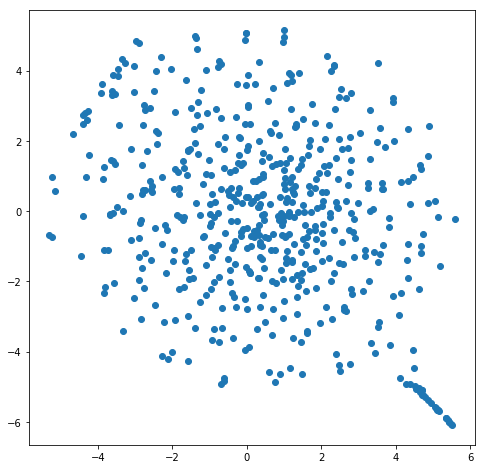

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y)

#for i, txt in enumerate(z):
#    ax.annotate(txt, (x[i],y[i]))

#plt.savefig('med2vec0626_emb_tsne.jpg')
plt.show()

In [6]:
with open('med2vec_emb0627_time_window_tsne.txt','w') as out:
    for i in range(553):
        out.write("\t".join([reverse_dictionary[i],str(emb_2d[i,0]),str(emb_2d[i,1])])+'\n')

In [19]:
from scipy.spatial.distance import cosine
aaa = trained_weights['W_emb']
cosine(emb_2d[dictionary['d127']],emb_2d[dictionary['p217']])

0.38922136645494998

In [4]:
def save_obj(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

for nn in range(13,14):
    print(nn,datetime.now())
    loadata = np.load('slice_data/0317data'+str(nn)+'.npz')
    x_=loadata['InputX3D']
    dmg_data = np.load('additional_fields/0317data'+str(nn)+'_additionalFields.npz')
    x_dmg = dmg_data['values']
    x_dmg[:,2] = abs(x_dmg[:,3]-2)
    x_dmg = x_dmg[:,:3]
    seqs,demos = [],[]
    for i in range(len(x_)):
        if i > 0:
            seqs.append([-1])
            demos.append([0.,0.,0.])
        for j in range(len(x_[i])):
            if np.sum(x_[i][j]) > 0:
                seqs.append(np.where(x_[i][j]==True)[0].tolist())
                demos.append(x_dmg[i].tolist())
    
    save_obj(seqs,'med2vec_input/seqs'+str(nn)+'.pkl')
    save_obj(demos,'med2vec_input/demos'+str(nn)+'.pkl')

13 2018-06-27 14:39:40.327621


In [6]:
nn = 1
loadata = np.load('slice_data/0317data'+str(nn)+'.npz')
x_=loadata['InputX3D']
dmg_data = np.load('additional_fields/0317data'+str(nn)+'_additionalFields.npz')
x_dmg = dmg_data['values']
x_dmg[:,2] = abs(x_dmg[:,3]-2)
x_dmg = x_dmg[:,:3]
#seqs = load_obj('med2vec_input/seqs'+str(nn)+'.pkl')
#demos = load_obj('med2vec_input/demos'+str(nn)+'.pkl')
seqs, demos, times = [], [], []
tc = 0
for i in range(len(x_)):
    if i > 0:
        seqs.append([-1])
        demos.append([0.,0.,0.])
    for j in range(len(x_[i])):
        if np.sum(x_[i][j]) > 0:
            seqs.append(np.where(x_[i][j]==True)[0].tolist())
            demos.append(x_dmg[i].tolist())
            times.append(tc)
        tc += 1

In [ ]:

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    for epoch in range(5):
        for nn in range(53):
            loadata = np.load('slice_data/0317data'+str(nn)+'.npz')
            x_=loadata['InputX3D']
            dmg_data = np.load('additional_fields/0317data'+str(nn)+'_additionalFields.npz')
            x_dmg = dmg_data['values']
            x_dmg[:,2] = abs(x_dmg[:,3]-2)
            x_dmg = x_dmg[:,:3]
            #seqs = load_obj('med2vec_input/seqs'+str(nn)+'.pkl')
            #demos = load_obj('med2vec_input/demos'+str(nn)+'.pkl')
            seqs, demos = [], []
            for i in range(len(x_)):
                if i > 0:
                    seqs.append([-1])
                    demos.append([0.,0.,0.])
                for j in range(len(x_[i])):
                    if np.sum(x_[i][j]) > 0:
                        seqs.append(np.where(x_[i][j]==True)[0].tolist())
                        demos.append(x_dmg[i].tolist())
                    #else:
                        #seqs.append([-1])
                        #demos.append([0.,0.,0.])
            n_batches = int(np.ceil(float(len(seqs)) / float(batchSize)))
            total_loss,total_visit_loss = 0,0
            for index in random.sample(range(n_batches), n_batches):
                batchX = seqs[batchSize*index:batchSize*(index+1)]
                batchD = demos[batchSize*index:batchSize*(index+1)]
                batchX, mask_in, iVec, jVec = padMatrix(batchX)
                feed_dict={x:batchX,d:batchD,mask:mask_in,iVector:iVec,jVector:jVec}
                loss_val = session.run([optimizer, total_cost,visit_cost,tparams], feed_dict=feed_dict)
                total_loss += loss_val[1]
                total_visit_loss += loss_val[2]

            avg_loss = total_loss / n_batches
            avg_visit_loss = total_visit_loss / n_batches
            print(datetime.now(),"epoch:",epoch,nn,"loss:",avg_loss,avg_visit_loss,avg_loss-avg_visit_loss)
            print(np.mean(loss_val[-1]['W_emb']),np.mean(loss_val[-1]['b_emb']))
        #save_obj(loss_val[-1], 'med2vec_emb0626_adadelta_'+str(epoch)+'.pkl')

2018-06-27 17:40:20.752563 epoch: 0 0 loss: 233.431480276 227.114361342 6.31711893436
5.90687e-05 0.00248667
2018-06-27 17:41:44.564350 epoch: 0 1 loss: 221.390166518 215.073248107 6.31691841176
0.00021934 0.0208227
2018-06-27 17:43:08.016609 epoch: 0 2 loss: 207.377756993 201.061130432 6.31662656101
0.000414918 0.0470061
2018-06-27 17:44:31.729881 epoch: 0 3 loss: 192.913826264 186.597601033 6.31622523141
0.000612021 0.0614483
2018-06-27 17:45:54.686219 epoch: 0 4 loss: 186.472488435 180.156779496 6.31570893956
0.000774014 0.0666746
2018-06-27 17:47:24.826472 epoch: 0 5 loss: 181.729097132 175.41390366 6.31519347206
0.000879209 0.069424
2018-06-27 17:48:56.389614 epoch: 0 6 loss: 179.590410013 173.275676514 6.31473349933
0.00093529 0.0712212
2018-06-27 17:50:27.411700 epoch: 0 7 loss: 180.049035572 173.734627405 6.31440816698
0.000949356 0.0723323
2018-06-27 17:51:50.818051 epoch: 0 8 loss: 180.49378733 174.179614157 6.31417317312
0.000940036 0.0730038
2018-06-27 17:53:20.515453 epoch

In [4]:
trained_weights['W_hidden'].shape

(103, 200)